# Fitting a quadriatic form
Here lets consider the problem of optimizing elements of a coefficient matrix $A$ that generates a polynomial through a quadriatic form:
$$Q(x) \equiv y^T A y = ax^2 + 2bx + c$$
where 
$$ A \equiv \begin{bmatrix}
a & b/2 \\
b/2 & c \\
\end{bmatrix}
\quad 
y \equiv \begin{bmatrix} x & 1 \end{bmatrix}^T
$$

In [378]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

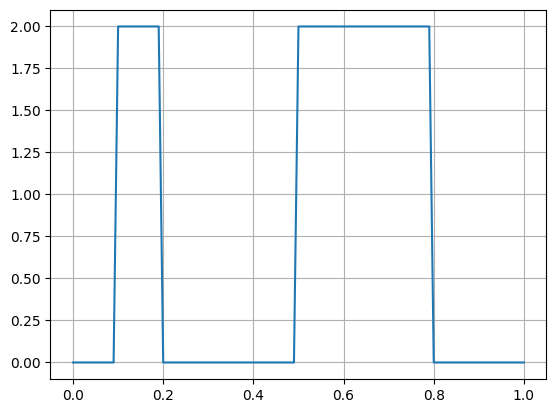

In [ ]:
# # parameters_ideal = torch.tensor([1,1,0.5],dtype=torch.float64)
# # plt.plot(w,np.abs(computeValues(parameters_ideal,w))); plt.grid()

# polynomial_target = torch.zeros(len(w))
# polynomial_target = torch.zeros(len(w))
# # polynomial_target[int(0.25*len(w)):int(0.75*len(w))] = 2
# polynomial_target[int(0.1*len(w)):int(0.2*len(w))] = 2
# polynomial_target[int(0.5*len(w)):int(0.8*len(w))] = 2
# plt.plot(w,abs(polynomial_target)); plt.grid()


c:\Users\DELL\miniconda3\envs\torch\lib\site-packages\torch\_tensor.py:734: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


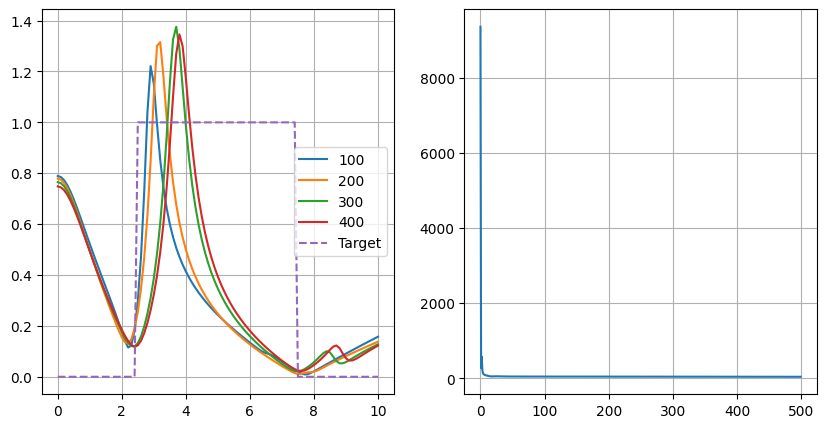

In [622]:
w = torch.linspace(0,10,101,dtype=torch.complex128) # for plotting

# parameters_ideal = torch.tensor([1,1,0.5],dtype=torch.float64)
# plt.plot(w,np.abs(computeValues(parameters_ideal,w))); plt.grid()

polynomial_target = torch.zeros(len(w))
polynomial_target[int(0.25*len(w)):int(0.75*len(w))] = 1
# polynomial_target[int(0.5*len(w)):int(0.75*len(w))] = 2

# ====================================================================
parameters = torch.tensor(0.01*np.ones(12),dtype=torch.float64,requires_grad=True)
# parameters = torch.tensor(0.01*np.random.rand(12),dtype=torch.float64,requires_grad=True)

def getSection(LCG_bundle,w):
    L,C,G = LCG_bundle
    matrix_tensor = torch.stack([
        torch.stack([1 - L * C * (w**2), 1j*L * w], dim=-1),    # Row 1 of each matrix
        torch.stack([G+1j*C * w, torch.ones_like(w)], dim=-1)  # Row 2 of each matrix
    ], dim=-2)  # Combine rows into a matrix
    return matrix_tensor
    
def computeValues(parameters, w):
    
    # Stack the components into a 3D tensor
    matrix_tensor1 = getSection(parameters[0:3],w)
    matrix_tensor2 = getSection(parameters[3:6],w)
    matrix_tensor3 = getSection(parameters[6:9],w)
    matrix_tensor4 = getSection(parameters[9:12],w)
    
    matrix_tensor_final = matrix_tensor1 @ matrix_tensor2 @ matrix_tensor3 @ matrix_tensor4
    Q = matrix_tensor_final[:,0,0]/matrix_tensor_final[:,1,0]
    return Q

def computeError(parameters):
    polynomial_w = computeValues(parameters,w)
    # polynomial_target = computeValues(parameters_ideal,w)
    # loss = torch.nn.MSELoss()(polynomial_w,polynomial_target)
    loss = torch.sum(
        torch.abs(polynomial_w-polynomial_target)**2
    )
    return loss
# ====================================================================
fig, axes = plt.subplots(1,2,figsize=(10,5)); legend = []; e = []
optimizer = torch.optim.Adam([parameters], lr=0.05) # Adaptive algorithm, better
run_iter = 500; run_interval = 100; run_skip = 0
for i in range(run_iter):
    optimizer.zero_grad()
    f = computeError(parameters)
    # f = torch.nn.MSELoss()(parameters_ideal,parameters)
    f.backward()
    optimizer.step()
    e.append(f.item())
    if(i%run_interval==0 and i> run_skip):
        # print(f'Iteration {i} : {parameters};  f = {f.item()}')
        axes[0].plot(w,abs(computeValues(parameters,w)).detach().numpy())
        # axes[0].plot(w,10*np.log10(abs(computeValues(parameters,w)).detach().numpy()))
        legend.append(i)
legend.append('Target')
# axes.plot(w,abs(computeValues(parameters_ideal,w)).detach().numpy(),linestyle='dashed')
# print(f'Ideal parameters: {parameters_ideal}')
axes[0].plot(w,abs(polynomial_target).detach().numpy(),linestyle='dashed')
# axes[0].plot(w,10*np.log10(abs(polynomial_target)).detach().numpy(),linestyle='dashed')
axes[0].legend(legend)
axes[0].grid('on')
axes[1].plot(e); axes[1].grid('on')